<a href="https://colab.research.google.com/github/soyyoon/ML_project/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모델 학습을 위한 데이터 전처리

In [ ]:
import numpy as np
import os
import time
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score

# 4개의 모델 임포트
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/ML_Project'
SAVE_PATH_TRAIN = os.path.join(BASE_DIR, 'colored_mnist_train.npz')
SAVE_PATH_VAL = os.path.join(BASE_DIR, 'colored_mnist_val.npz')

NUM_CLASSES_DIGIT = 10  # 숫자 (0~9)
NUM_CLASSES_COLOR = 7   # 색상 (무지개 7색)

# 학습 데이터 로드
print("학습 데이터 로딩 중...")
train_data = np.load(SAVE_PATH_TRAIN)
X_train_color = train_data['images']
y_train_digit = train_data['labels_digit']
y_train_fg = train_data['labels_fg']
y_train_bg = train_data['labels_bg']

# 테스트 데이터 로드
print("테스트 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL)
X_val_color = val_data['images']
y_val_digit = val_data['labels_digit']
y_val_fg = val_data['labels_fg']
y_val_bg = val_data['labels_bg']

print(f"\n원본 학습 데이터 Shape: {X_train_color.shape}")


# --- 2. 데이터 전처리 ---
# 2-1. 색상 분류용 (Color 3D -> 1D Flatten)
X_train_flat_color = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat_color = X_val_color.reshape(X_val_color.shape[0], -1)

print(f"색상 분류용 데이터 (Color): {X_train_flat_color.shape}")

Mounted at /content/drive
학습 데이터 로딩 중...
테스트 데이터 로딩 중...

원본 학습 데이터 Shape: (60000, 28, 28, 3)
색상 분류용 데이터 (Color): (60000, 2352)


## 그레이스케일 없이 모델 학습

In [ ]:
print("\n--- 3종 모델 학습 시작 (총 9개) ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # 1. RandomForest
    ("RandomForest - Digit", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_color, y_train_digit),
    ("RandomForest - FG Color", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_color, y_train_fg),
    ("RandomForest - BG Color", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_color, y_train_bg),

    # 2. XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT), X_train_flat_color, y_train_digit),
    ("XGBoost - FG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR), X_train_flat_color, y_train_fg),
    ("XGBoost - BG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR), X_train_flat_color, y_train_bg),

    # 3. LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1), X_train_flat_color, y_train_digit),
    ("LightGBM - FG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1), X_train_flat_color, y_train_fg),
    ("LightGBM - BG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1), X_train_flat_color, y_train_bg),
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model # 학습 완료된 모델을 이름과 함께 저장

print("\n--- 모든 모델 학습 완료 ---")


--- 3종 모델 학습 시작 (총 12개) ---


Overall Training Progress: 100%|██████████| 9/9 [26:43<00:00, 178.19s/it]

--- 모든 모델 학습 완료 ---


## 그레이스케일 미적용 모델 성능 평가

In [ ]:
def evaluate_model(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 모델 이름에 따라 올바른 테스트 데이터를 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_color, y_val_digit
    elif "FG Color" in model_name:
        X_val, y_val = X_val_flat_color, y_val_fg
    else: # BG Color
        X_val, y_val = X_val_flat_color, y_val_bg

    y_pred = model_obj.predict(X_val)
    y_proba = model_obj.predict_proba(X_val)

    print(classification_report(y_val, y_pred, digits=4))
    auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
    print(f"** Weighted-Average AUC: {auc:.4f} **")

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models.items():
    evaluate_model(name, model)


--- 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9518    0.9807    0.9660       986
           1     0.9561    0.9899    0.9727       991
           2     0.9452    0.9404    0.9428       973
           3     0.9337    0.9086    0.9210      1007
           4     0.9532    0.9551    0.9542      1046
           5     0.9430    0.9305    0.9367       978
           6     0.9558    0.9736    0.9646      1022
           7     0.9521    0.9502    0.9511      1024
           8     0.9555    0.9036    0.9288       975
           9     0.9249    0.9379    0.9313       998

    accuracy                         0.9472     10000
   macro avg     0.9471    0.9470    0.9469     10000
weighted avg     0.9472    0.9472    0.9470     10000

** Weighted-Average AUC: 0.9971 **

===== RandomForest - FG Color =====
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000  

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9584    0.9807    0.9694       986
           1     0.9720    0.9798    0.9759       991
           2     0.9286    0.9486    0.9385       973
           3     0.9459    0.9037    0.9243      1007
           4     0.9469    0.9551    0.9510      1046
           5     0.9357    0.9376    0.9367       978
           6     0.9656    0.9618    0.9637      1022
           7     0.9595    0.9492    0.9543      1024
           8     0.9436    0.9272    0.9353       975
           9     0.9249    0.9379    0.9313       998

    accuracy                         0.9482     10000
   macro avg     0.9481    0.9482    0.9481     10000
weighted avg     0.9482    0.9482    0.9481     10000

** Weighted-Average AUC: 0.9970 **

===== LightGBM - FG Color =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1476
           1     1.0000    1.0000    1.0000      1413
           2     1.0000    0.9993    0.9996      1424
           3     1.0000    1.0000    1.0000      1375
           4     1.0000    1.0000    1.0000      1446
           5     1.0000    1.0000    1.0000      1444
           6     0.9993    1.0000    0.9996      1422

    accuracy                         0.9999     10000
   macro avg     0.9999    0.9999    0.9999     10000
weighted avg     0.9999    0.9999    0.9999     10000

** Weighted-Average AUC: 1.0000 **

===== LightGBM - BG Color =====


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1453
           1     1.0000    1.0000    1.0000      1387
           2     1.0000    1.0000    1.0000      1472
           3     1.0000    1.0000    1.0000      1374
           4     1.0000    1.0000    1.0000      1344
           5     1.0000    1.0000    1.0000      1501
           6     1.0000    1.0000    1.0000      1469

    accuracy                         1.0000     10000
   macro avg     1.0000    1.0000    1.0000     10000
weighted avg     1.0000    1.0000    1.0000     10000

** Weighted-Average AUC: 1.0000 **


--- Confusion Matrix 생성 중... 잠시만 기다려 퀸 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


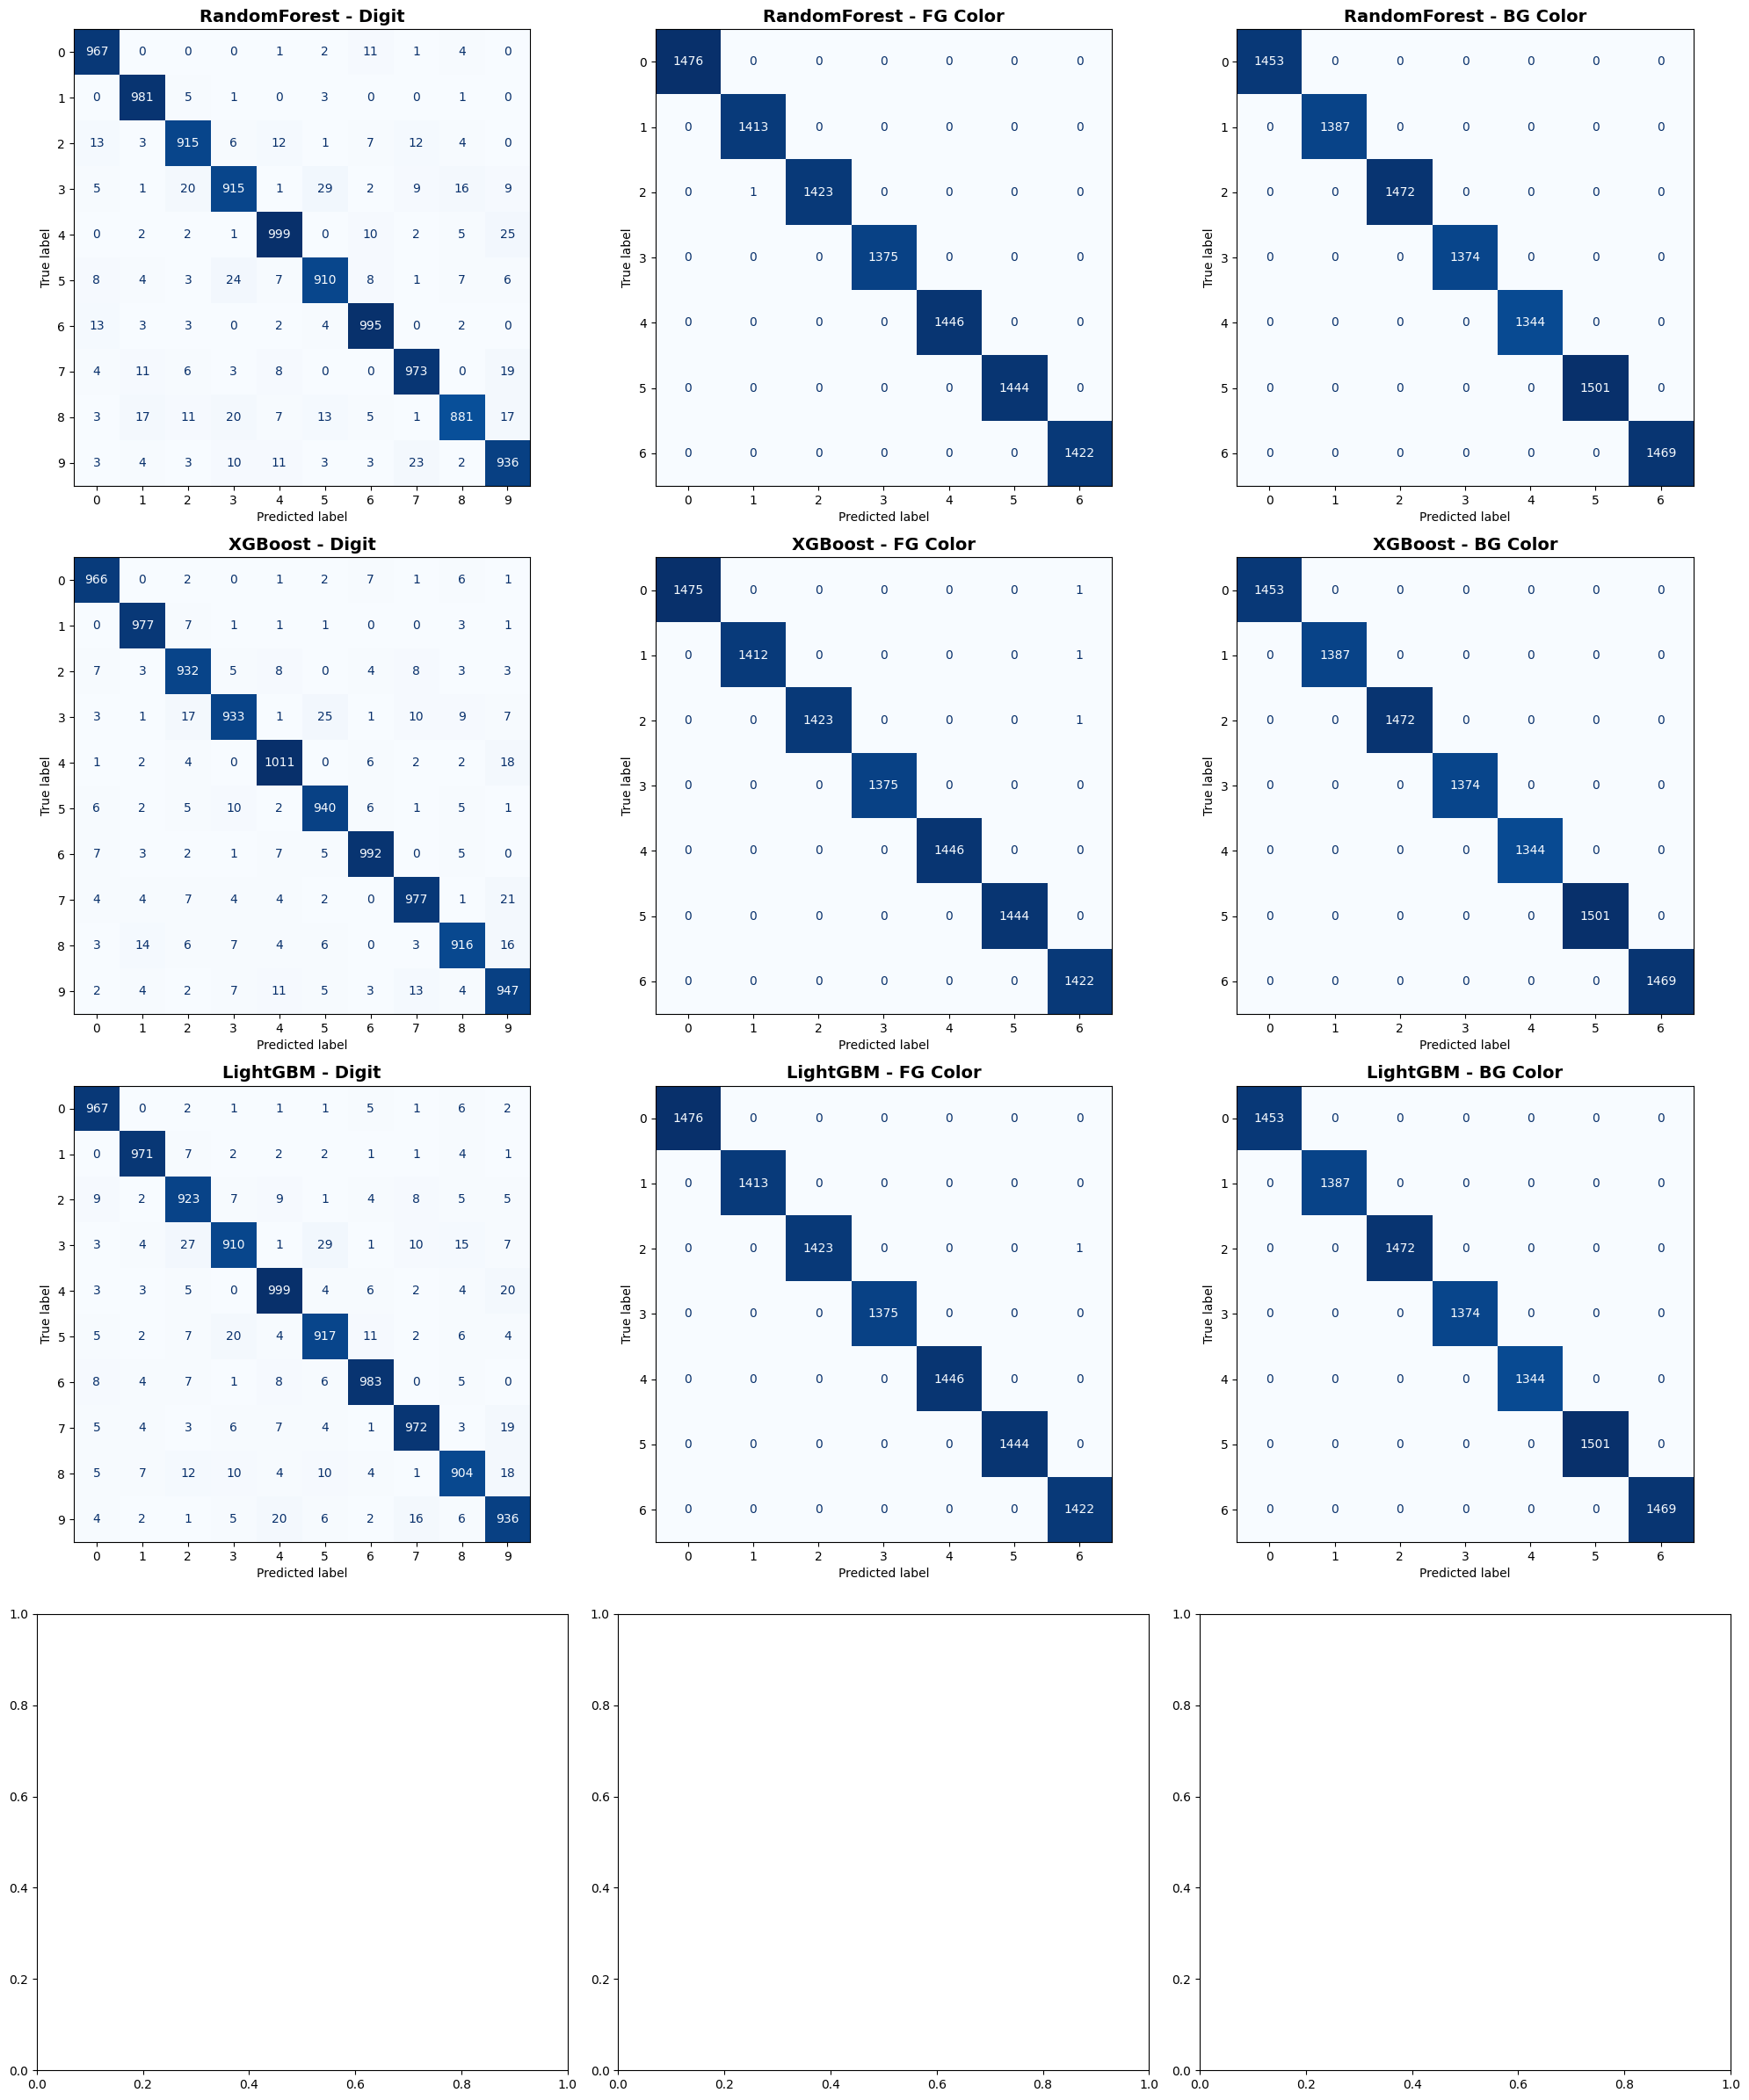

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 3, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_color
        y_val = y_val_digit
    elif "FG Color" in name: # 전경색
        X_val = X_val_flat_color
        y_val = y_val_fg
    elif "BG Color" in name: # 배경색
        X_val = X_val_flat_color
        y_val = y_val_bg
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## 그레이스케일 적용 모델 학습

In [ ]:
# 2-2. 숫자 분류용 (Color 3D -> Grayscale 2D -> 1D Flatten)
X_train_gray = np.dot(X_train_color[...,:3], [0.299, 0.587, 0.114])
X_val_gray = np.dot(X_val_color[...,:3], [0.299, 0.587, 0.114])
X_train_flat_gray = X_train_gray.reshape(X_train_gray.shape[0], -1)
X_val_flat_gray = X_val_gray.reshape(X_val_gray.shape[0], -1)

print(f"숫자 분류용 데이터 (Gray): {X_train_flat_gray.shape}")

print("\n--- 3종 모델 학습 시작 ---")

# 학습할 모델과 데이터를 '작업 목록'으로 정의
training_jobs = [
    # 1. RandomForest
    ("RandomForest - Digit", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat_gray, y_train_digit),

    # 2. XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT), X_train_flat_gray, y_train_digit),

    # 3. LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1), X_train_flat_gray, y_train_digit),
]

# 학습된 모델들을 저장할 딕셔너리
trained_models = {}

# TQDM으로 작업 목록을 감싸서 진행도 표시
for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    model.fit(X_train_data, y_train_data)
    trained_models[name] = model # 학습 완료된 모델을 이름과 함께 저장

print("\n--- 모든 모델 학습 완료 ---")

숫자 분류용 데이터 (Gray): (60000, 784)

--- 3종 모델 학습 시작 ---


Overall Training Progress: 100%|██████████| 3/3 [07:45<00:00, 155.30s/it]


--- 모든 모델 학습 완료 ---


## 그레이스케일 적용 모델 성능 평가

In [ ]:
def evaluate_model(model_name, model_obj):
    print(f"\n===== {model_name} =====")

    # 모델 이름에 따라 올바른 테스트 데이터를 선택
    if "Digit" in model_name:
        X_val, y_val = X_val_flat_gray, y_val_digit

    y_pred = model_obj.predict(X_val)
    y_proba = model_obj.predict_proba(X_val)

    print(classification_report(y_val, y_pred, digits=4))
    auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
    print(f"** Weighted-Average AUC: {auc:.4f} **")

print("\n--- 최종 성능 평가 (Valdation Set) ---")

# 학습된 모델들을 순회하며 평가
for name, model in trained_models.items():
    evaluate_model(name, model)


--- 최종 성능 평가 (Valdation Set) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9573    0.9767    0.9669       986
           1     0.9561    0.9879    0.9717       991
           2     0.9448    0.9507    0.9477       973
           3     0.9406    0.9116    0.9259      1007
           4     0.9552    0.9579    0.9566      1046
           5     0.9419    0.9284    0.9351       978
           6     0.9596    0.9755    0.9675      1022
           7     0.9550    0.9531    0.9541      1024
           8     0.9590    0.9108    0.9342       975
           9     0.9261    0.9419    0.9339       998

    accuracy                         0.9496     10000
   macro avg     0.9495    0.9495    0.9494     10000
weighted avg     0.9496    0.9496    0.9495     10000

** Weighted-Average AUC: 0.9973 **

===== XGBoost - Digit =====
              precision    recall  f1-score   support

           0     0.9554    0.9767    0.9659       986


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9533    0.9726    0.9629       986
           1     0.9520    0.9798    0.9657       991
           2     0.9109    0.9353    0.9229       973
           3     0.9455    0.8957    0.9199      1007
           4     0.9331    0.9474    0.9402      1046
           5     0.9267    0.9305    0.9286       978
           6     0.9575    0.9481    0.9528      1022
           7     0.9536    0.9424    0.9479      1024
           8     0.9371    0.9015    0.9190       975
           9     0.9103    0.9259    0.9180       998

    accuracy                         0.9380     10000
   macro avg     0.9380    0.9379    0.9378     10000
weighted avg     0.9381    0.9380    0.9379     10000

** Weighted-Average AUC: 0.9955 **


--- Confusion Matrix 생성 중 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


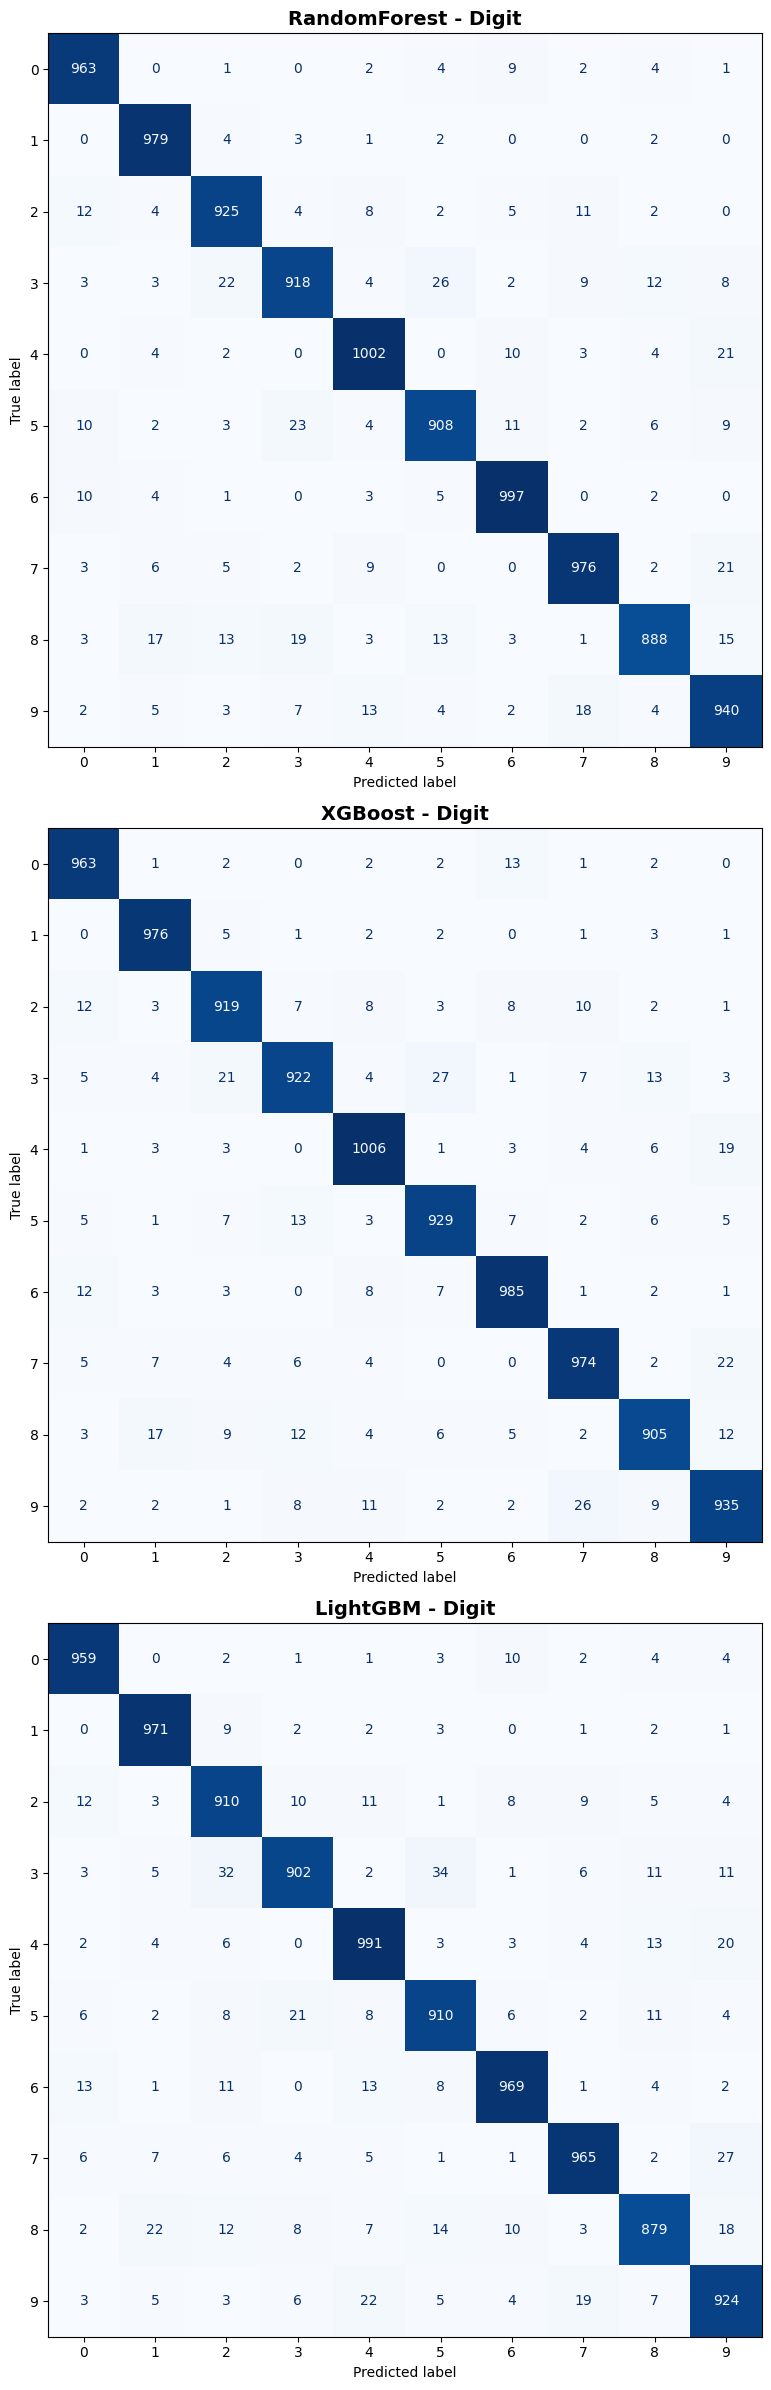

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 1, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## HOG 피처 추가 모델 학습

In [ ]:
# HOG 파라미터 (이 기본값이 MNIST에 최적화되어 있어)
ppc = 8
cpb = 2

# 학습 데이터에서 HOG 피처 추출
X_train_hog = np.array([hog(image, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False) for image in tqdm(X_train_gray, desc="학습 데이터 HOG 변환")])

# 테스트 데이터에서 HOG 피처 추출
X_val_hog = np.array([hog(image, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb), visualize=False) for image in tqdm(X_val_gray, desc="검증 데이터 HOG 변환")])

print(f"HOG 피처 Shape: {X_train_hog.shape}")

# --- 4. HOG 피처로 모델 학습 및 비교 ---
print("\n--- HOG 피처로 최종 모델 학습 시작 ---")

# --- 4-1. RandomForest with HOG ---
print("[1/2] RandomForest 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_rf_hog = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
digit_model_rf_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 4-2. XGBoost with HOG ---
print("[2/2] XGBoost 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_xgb_hog = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT)
digit_model_xgb_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

# --- 4-3. LightGBM with HOG ---
print("[3/3] LightGBM 모델 학습 중 (HOG)...")
start_time = time.time()
digit_model_lgb_hog = lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT)
digit_model_lgb_hog.fit(X_train_hog, y_train_digit)
print(f" -> 학습 완료 (소요 시간: {time.time() - start_time:.2f}초)")

검증 데이터 HOG 변환: 100%|██████████| 10000/10000 [00:01<00:00, 7352.93it/s]


HOG 피처 Shape: (60000, 144)

--- HOG 피처로 최종 모델 학습 시작 ---
[1/2] RandomForest 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 23.13초)
[2/2] XGBoost 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 40.65초)
[3/3] LightGBM 모델 학습 중 (HOG)...
 -> 학습 완료 (소요 시간: 19.61초)


## HOG 피처 추가 모델 성능

In [ ]:
print("\n--- HOG 모델 최종 성능 평가 (Validation Set) ---")

def evaluate_model_hog(model, model_name, X_val_hog_data, y_val_digit_data):
    print(f"\n===== {model_name} =====")
    y_pred = model.predict(X_val_hog_data)
    y_proba = model.predict_proba(X_val_hog_data)

    print(classification_report(y_val_digit_data, y_pred, digits=4))
    auc = roc_auc_score(y_val_digit_data, y_proba, multi_class='ovr', average='weighted')
    print(f"** Weighted-Average AUC: {auc:.4f} **")

# HOG로 학습된 두 모델의 성능을 나란히 출력
evaluate_model_hog(digit_model_rf_hog, "RandomForest - Digit (HOG)", X_val_hog, y_val_digit)
evaluate_model_hog(digit_model_xgb_hog, "XGBoost - Digit (HOG)", X_val_hog, y_val_digit)
evaluate_model_hog(digit_model_lgb_hog, "LightGBM - Digit (HOG)", X_val_hog, y_val_digit)


--- HOG 모델 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit (HOG) =====
              precision    recall  f1-score   support

           0     0.9799    0.9909    0.9854       986
           1     0.9909    0.9919    0.9914       991
           2     0.9835    0.9805    0.9820       973
           3     0.9706    0.9523    0.9614      1007
           4     0.9773    0.9866    0.9819      1046
           5     0.9709    0.9888    0.9797       978
           6     0.9892    0.9834    0.9863      1022
           7     0.9812    0.9668    0.9739      1024
           8     0.9631    0.9631    0.9631       975
           9     0.9660    0.9689    0.9675       998

    accuracy                         0.9773     10000
   macro avg     0.9773    0.9773    0.9773     10000
weighted avg     0.9773    0.9773    0.9773     10000

** Weighted-Average AUC: 0.9995 **

===== XGBoost - Digit (HOG) =====
              precision    recall  f1-score   support

           0     0.9850    0.9970 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.9820    0.9959    0.9889       986
           1     0.9920    0.9950    0.9935       991
           2     0.9876    0.9836    0.9856       973
           3     0.9808    0.9652    0.9730      1007
           4     0.9791    0.9876    0.9833      1046
           5     0.9888    0.9939    0.9913       978
           6     0.9932    0.9941    0.9936      1022
           7     0.9814    0.9795    0.9804      1024
           8     0.9794    0.9733    0.9763       975
           9     0.9779    0.9739    0.9759       998

    accuracy                         0.9842     10000
   macro avg     0.9842    0.9842    0.9842     10000
weighted avg     0.9842    0.9842    0.9842     10000

** Weighted-Average AUC: 0.9997 **


--- Confusion Matrix 생성 중 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


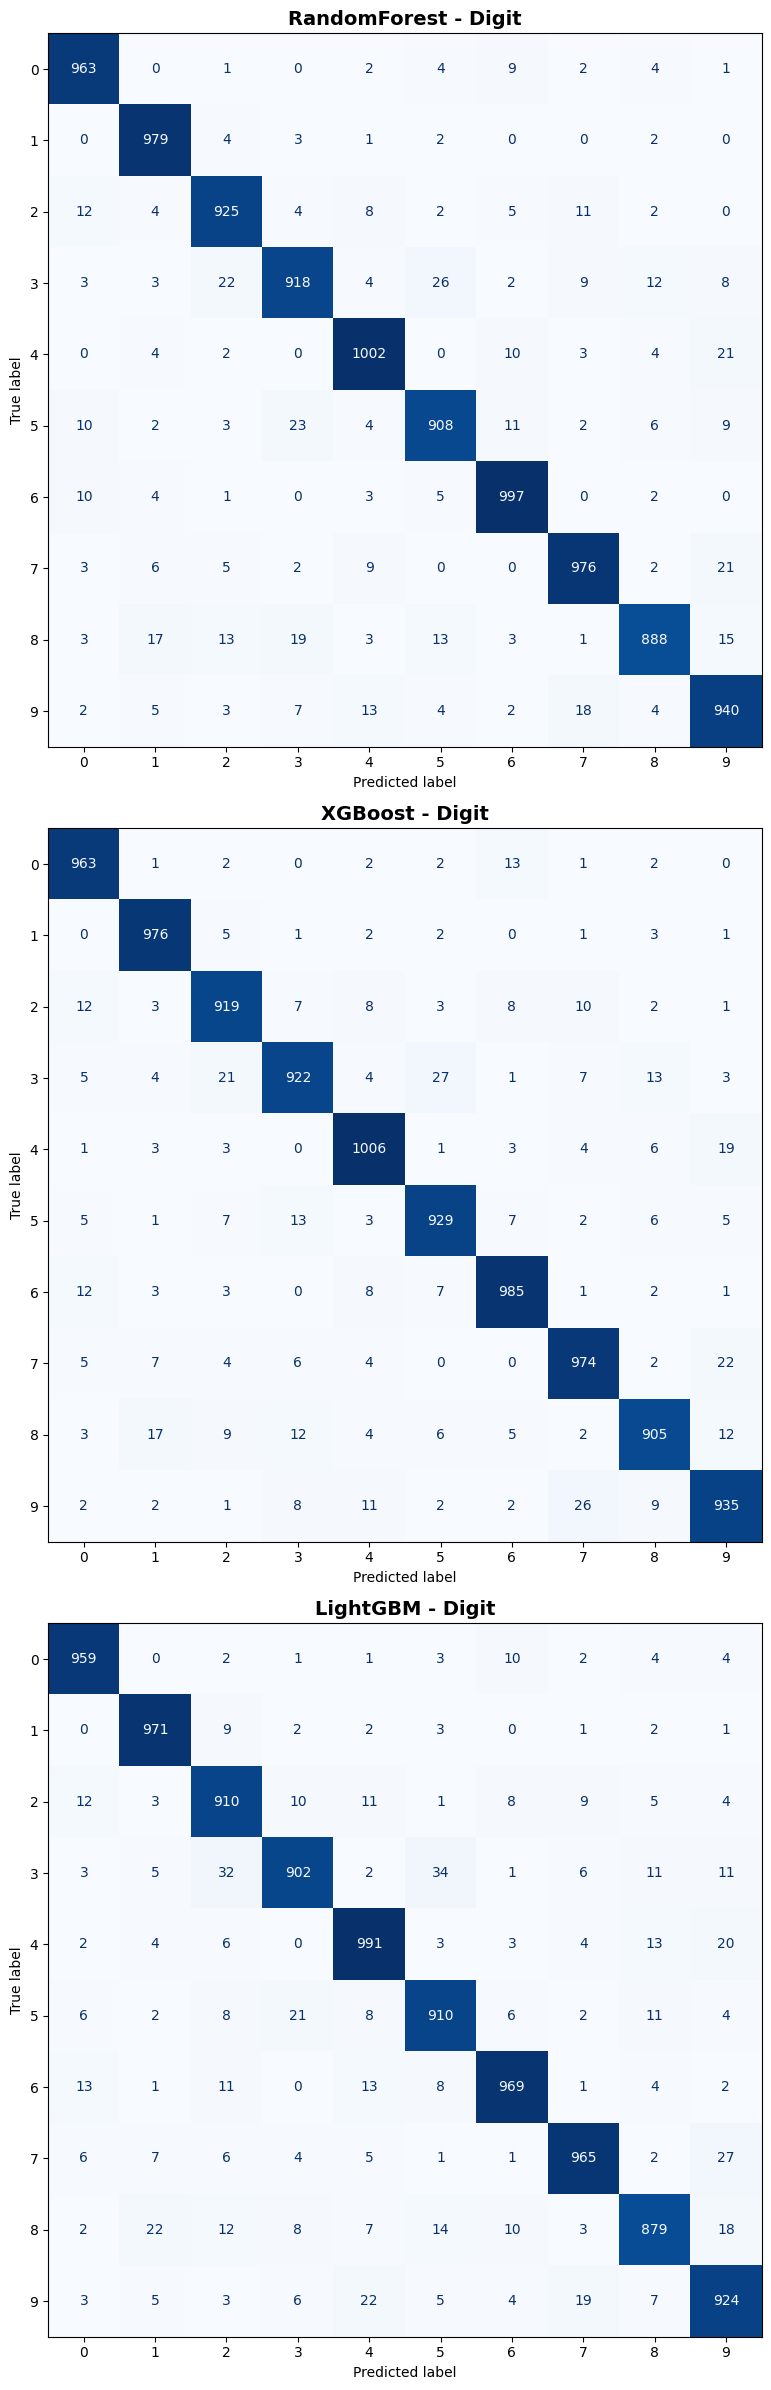

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(3, 1, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat_gray
        y_val = y_val_digit
    elif "FG Color" in name: # 전경색
        X_val = X_val_flat_color
        y_val = y_val_fg
    elif "BG Color" in name: # 배경색
        X_val = X_val_flat_color
        y_val = y_val_bg
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # cmap='Blues': 파란색 계열이 깔끔하고 이뻐.
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()

## 색상 처리 시간 단축

>>> [수정됨] 색상 데이터 다시 추출 중 (Threshold=0.1)...
>>> 변환 완료! 이제 전경색(FG)이 제대로 보일 거야.

>>> 모델 재학습 시작 (성능 떡상 가보자고!) 🚀...


 33%|███▎      | 2/6 [00:05<00:11,  2.80s/it]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
 83%|████████▎ | 5/6 [00:09<00:01,  1.53s/it]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


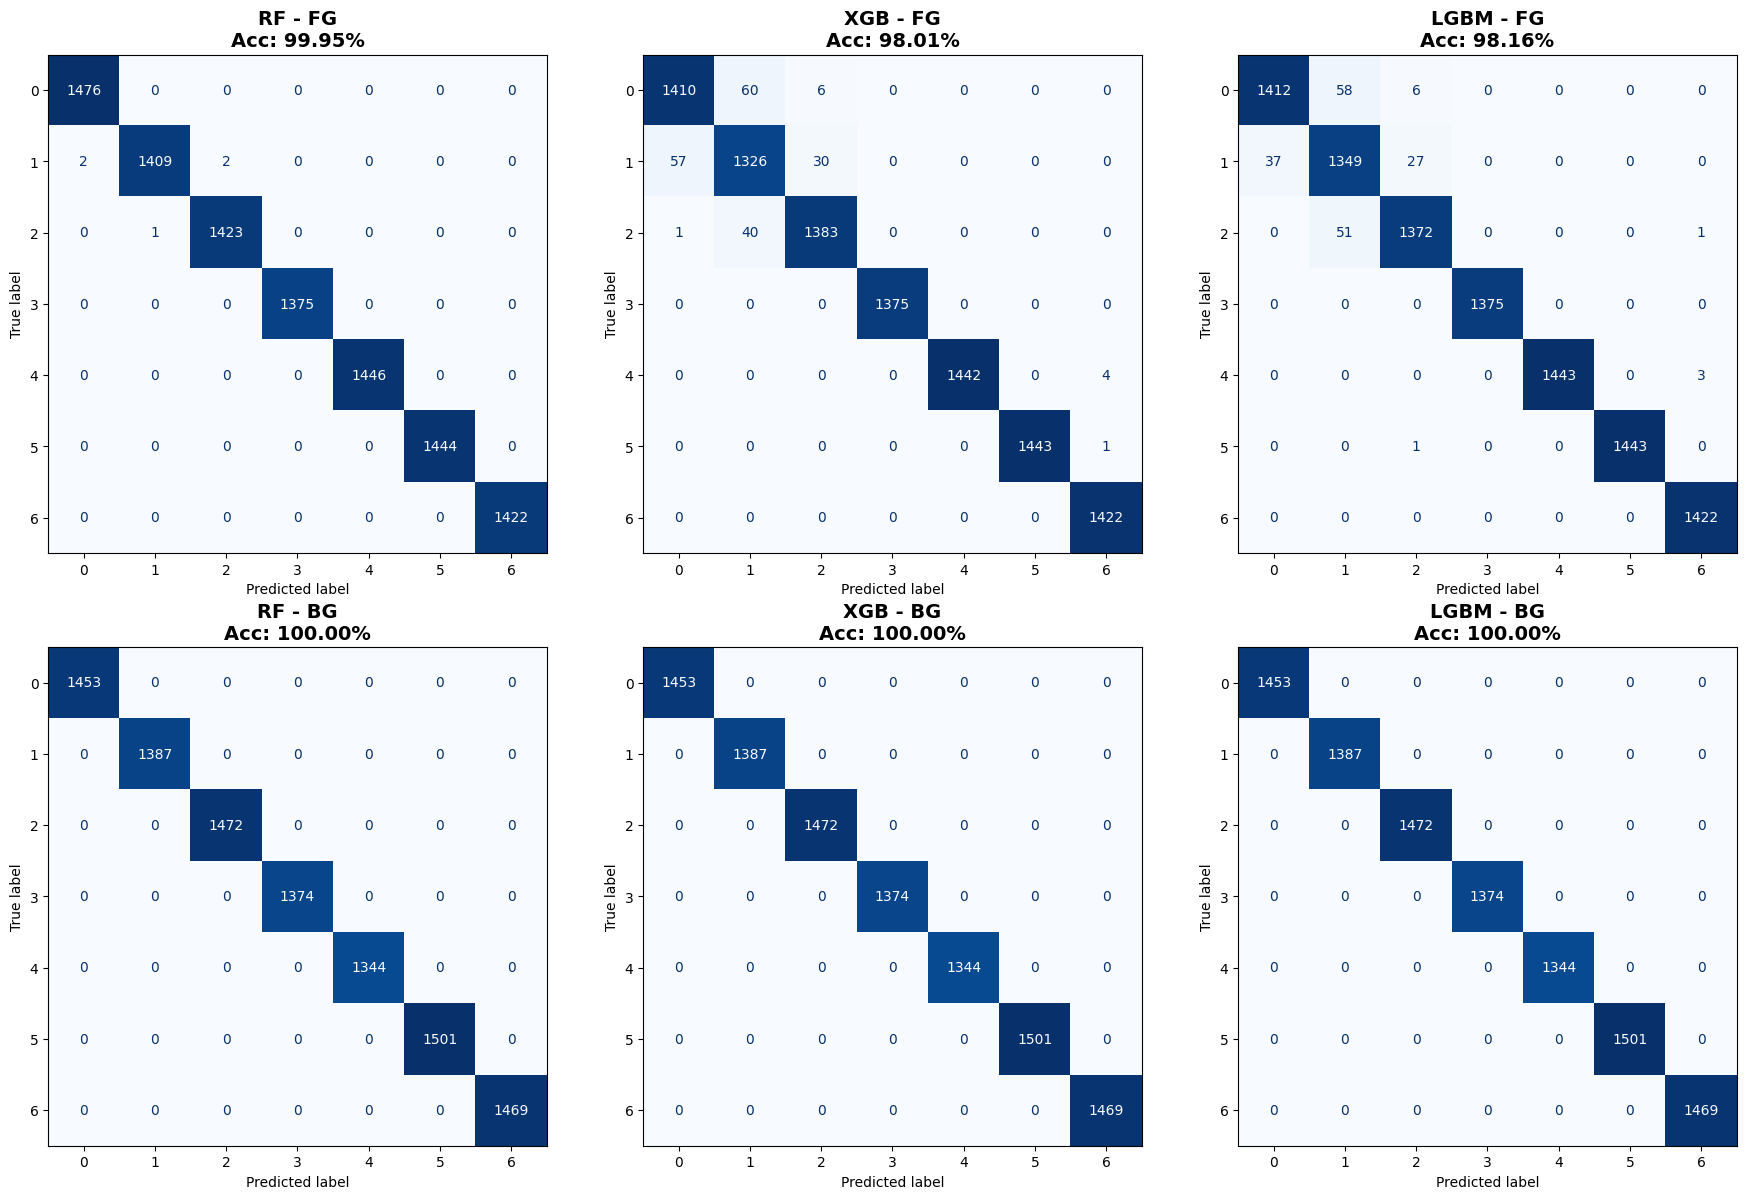


=== 🏆 Final Score (Redemption Round) ===
RF - FG         : 99.95%
XGB - FG        : 98.01%
LGBM - FG       : 98.16%
RF - BG         : 100.00%
XGB - BG        : 100.00%
LGBM - BG       : 100.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm

def extract_smart_color_features(images_color_flat, images_gray_flat, threshold=0.1):
    N = images_color_flat.shape[0]
    # shape 복구
    images_color = images_color_flat.reshape(N, 28, 28, 3)
    images_gray = images_gray_flat.reshape(N, 28, 28)

    fg_features = np.zeros((N, 3))
    bg_features = np.zeros((N, 3))

    # BG: 네 모서리 평균
    corners = images_color[:, [0, 0, -1, -1], [0, -1, 0, -1], :]
    bg_features = np.mean(corners, axis=1)

    # FG: 마스킹
    for i in range(N):
        mask = images_gray[i] > threshold
        if np.sum(mask) > 0:
            fg_features[i] = np.mean(images_color[i][mask], axis=0)
        else:
            # 여전히 숫자가 안 보이면 배경색으로 대체
            fg_features[i] = bg_features[i]

    return fg_features, bg_features

# --- [Step 2] 데이터 변환 (Correct Threshold) ---
print(">>> [수정됨] 색상 데이터 다시 추출 중 (Threshold=0.1)...")
# 학습 데이터
X_train_fg, X_train_bg = extract_smart_color_features(X_train_flat_color, X_train_flat_gray, threshold=0.1)
# 테스트 데이터
X_val_fg, X_val_bg = extract_smart_color_features(X_val_flat_color, X_val_flat_gray, threshold=0.1)
print(">>> 변환 완료 (FG)")

# --- [Step 3] 모델 학습 & 평가 (RF, XGB, LGBM Only) ---
training_jobs = [
    # 1. Foreground (전경색)
    ("RF - FG", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_fg, y_train_fg, X_val_fg, y_val_fg),
    ("XGB - FG", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_fg, y_train_fg, X_val_fg, y_val_fg),
    ("LGBM - FG", lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1), X_train_fg, y_train_fg, X_val_fg, y_val_fg),

    # 2. Background (배경색)
    ("RF - BG", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
    ("XGB - BG", xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
    ("LGBM - BG", lgb.LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbosity=-1), X_train_bg, y_train_bg, X_val_bg, y_val_bg),
]

# 시각화 설정
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print("\n>>> 모델 학습 시작")
results = {}

for i, (name, model, X_tr, y_tr, X_te, y_te) in enumerate(tqdm(training_jobs)):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    results[name] = acc

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)
    axes[i].set_title(f"{name}\nAcc: {acc:.2%}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== 🏆 Final Score (Redemption Round) ===")
for name, acc in results.items():
    print(f"{name:<15} : {acc:.2%}")